# Bayesian MLP on MNIST Classification Task

Import necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.special import softmax
from scipy.stats import multinomial
from scipy.stats import mode
import seaborn as sns
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
from tqdm.auto import tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read and preprocess small MNIST data

Load MNIST from sklearn:

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

Visualize a few examples (8x8 is extremely low-resolution, however suitable for our example):

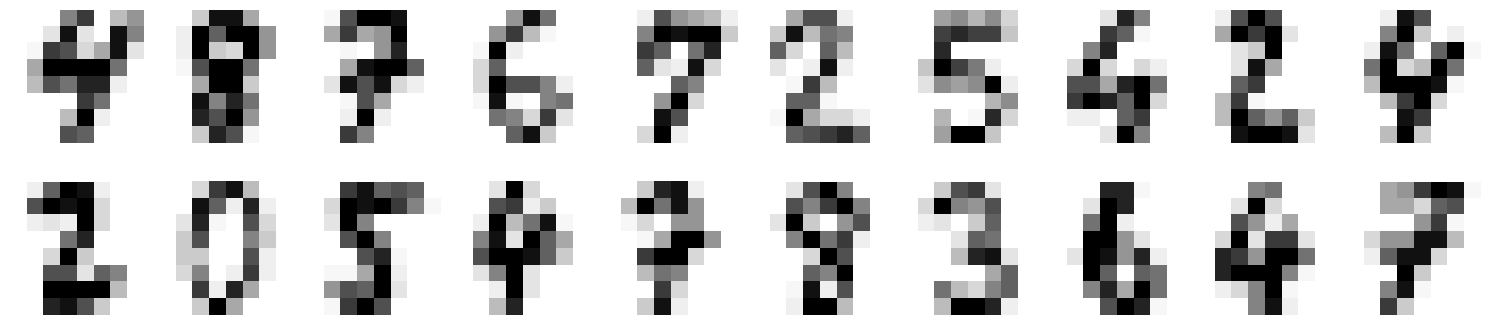

In [3]:
fig, ax = plt.subplots(2, 10, figsize=(15,4))
for i in range(2):
    for j in range(10):
        k = np.random.randint( X.shape[0] )
        ax[i,j].imshow( X[k,:].reshape(8,8), cmap="Greys" )
        ax[i,j].set_axis_off()
plt.tight_layout()

Standardize input data (otherwise choosing the same prior everywhere later does not make sense):

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

One-hot encode the labels for multi-class classification:

In [5]:
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

Split into training and test sets:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437, 10), (360, 10))

## Define and Fit Bayesian MLP

In [7]:
def relu( x ):
    return pt.maximum(0, x)

with pm.Model() as bayesian_mlp:
    # Prior variances for weights and biases (hyperparameters)
    sigma_W = 0.1
    sigma_b = 0.1

    # Priors for weights and biases of the hidden layer
    W1 = pm.Normal("W1", mu=0, sigma=sigma_W, shape=(64, 32))
    b1 = pm.Normal("b1", mu=0, sigma=sigma_b, shape=(32,))

    # Priors for weights and biases of the output layer
    W2 = pm.Normal("W2", mu=0, sigma=sigma_W, shape=(32, 10))
    b2 = pm.Normal("b2", mu=0, sigma=sigma_b, shape=(10,))

    # Forward pass: Hidden layer (ReLU activation)
    hidden_layer = relu( pt.dot(X_train, W1) + b1 ) 

    # Forward pass: Output layer (Softmax activation)
    output_logits = pt.dot(hidden_layer, W2) + b2
    output_probs = pt.special.softmax( output_logits, axis=1 )

    # Likelihood: Categorical distribution for multi-class classification
    y_obs = pm.Categorical("y_obs", p=output_probs, observed=np.argmax(y_train, axis=1))

    # Inference
    trace = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [W1, b1, W2, b2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Ok, this takes some time (2 minutes on my machine), but we have trained 4000 different models on MNIST!

## Look at network parameter distributions

E.g. for `b2`:

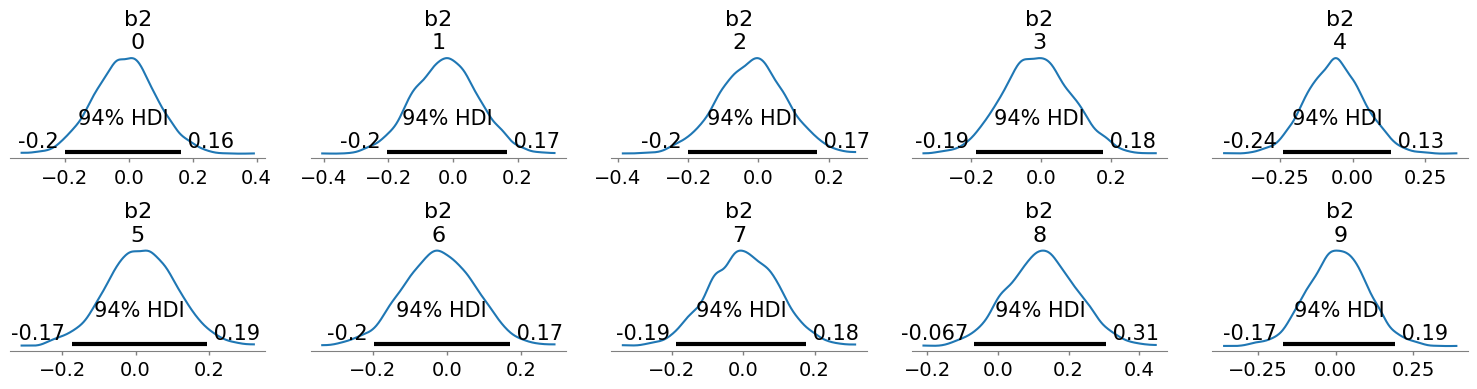

In [8]:
pm.plot_posterior( trace, var_names="b2", figsize=(15,4), grid=(2,5), point_estimate=None )
plt.tight_layout()

By the classic definition, none of the coefficients appear significant (do not include zero). Since deep learning models are typically overparameterized (in this case 2410 parameters for 64 input variables), the previously used notion of significance does not make much sense. Nevertheless, as we will see below, the Bayesian MLP performs sufficiently well.

## Compute Predictive Distributions

Extract posterior weights and biases:

In [9]:
W1_post = trace.posterior.W1.values.reshape( 4000, 64, 32 )
b1_post = trace.posterior.b1.values.reshape( 4000, 32 )
W2_post = trace.posterior.W2.values.reshape( 4000, 32, 10 )
b2_post = trace.posterior.b2.values.reshape( 4000, 10 )

Compute hidden layer values for each chain and sample:

In [10]:
def np_relu( x ):
    return np.maximum(0, x)

In [11]:
hidden_test = np_relu( np.dot( X_test, W1_post ) + b1_post )
hidden_test.shape

(360, 4000, 32)

Compute output probabilities for each chain: (perform matrix multiplications individually for each chain)

In [12]:
output_logits = np.stack( [np.dot( hidden_test[:,i,:], W2_post[i,:,:] ) + b2_post[i,:] for i in range(W1_post.shape[0])], axis=0 )
output_logits.shape

(4000, 360, 10)

In [13]:
output_probs = softmax( output_logits, axis=2 )
output_probs.shape

(4000, 360, 10)

Sample from likelihood for each chain to make predictions:

In [14]:
# This might be done in a more efficient way
preds = np.empty_like( output_probs[:,:,0] )
preds[:] = np.nan

for i in tqdm(range(output_probs.shape[0])): # chains
    for j in range(output_probs.shape[1]): # samples
        preds[i,j] = np.argmax( multinomial.rvs( n=1, p=output_probs[i,j,:] ) )
preds.shape

  0%|          | 0/4000 [00:00<?, ?it/s]

(4000, 360)

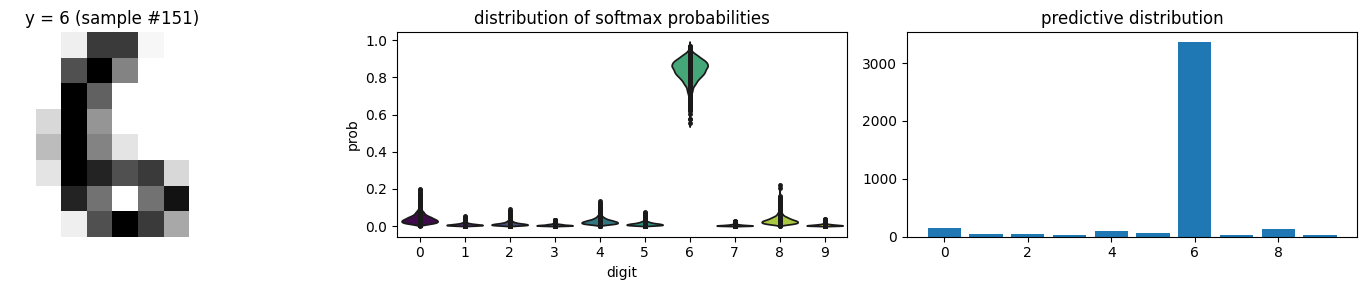

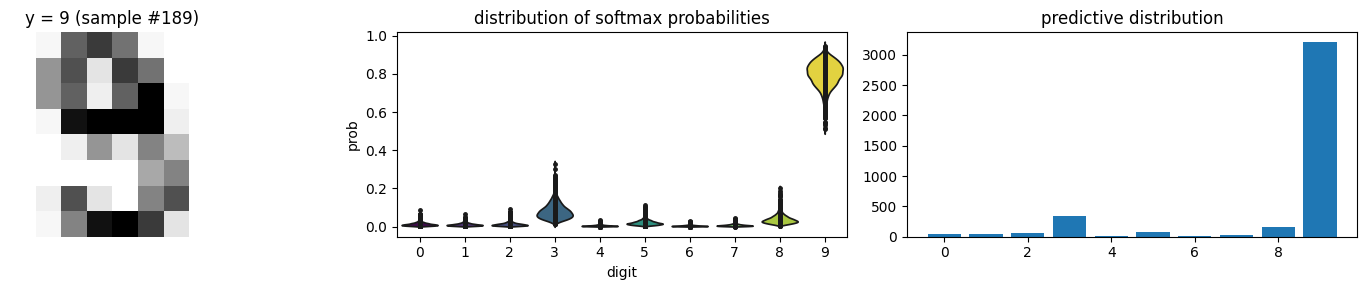

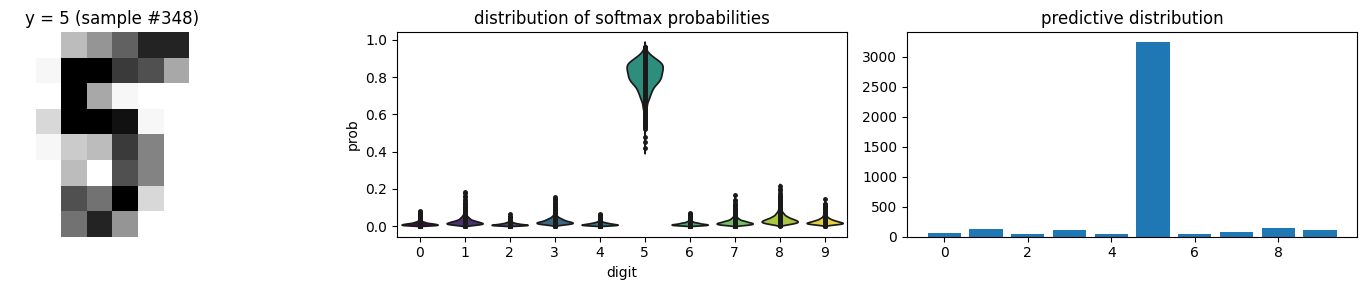

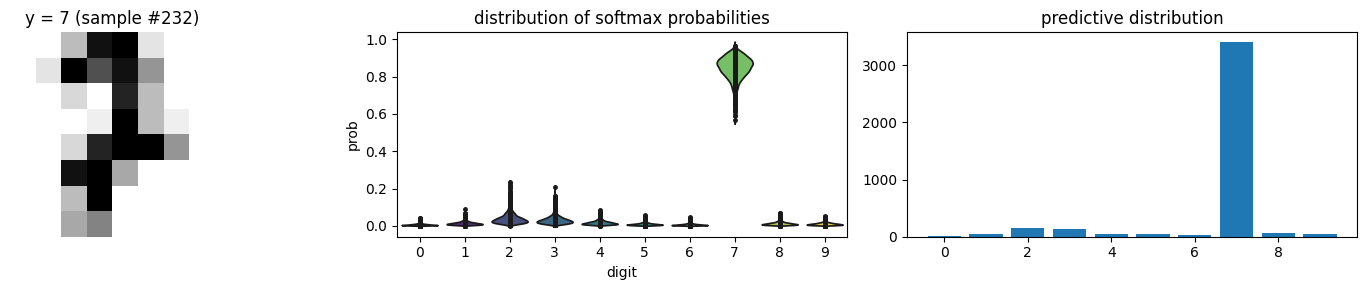

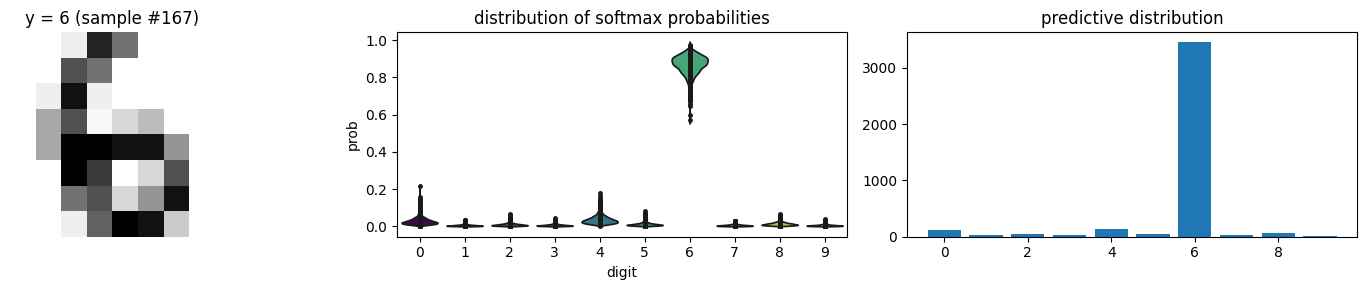

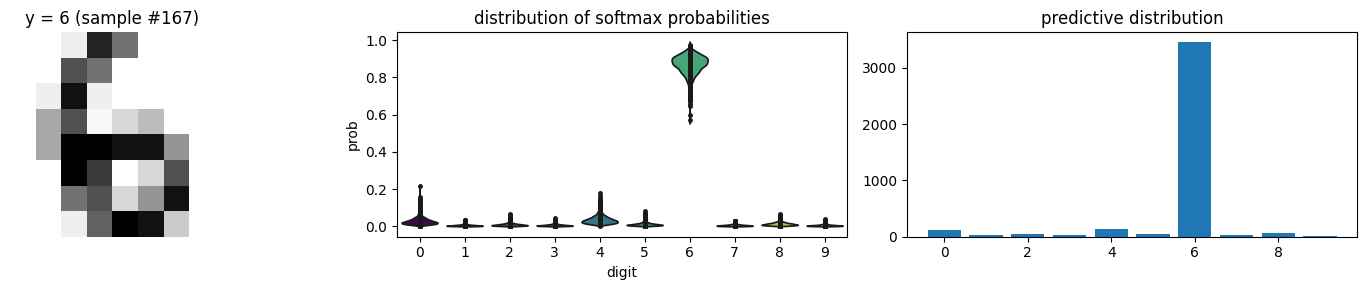

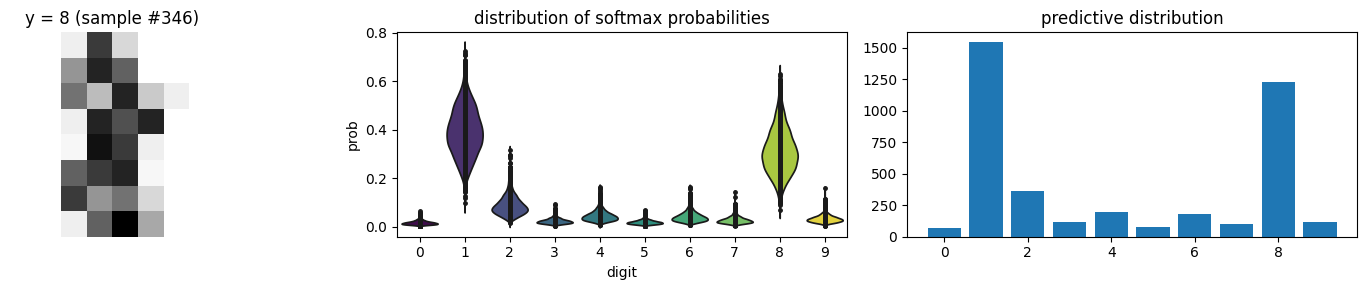

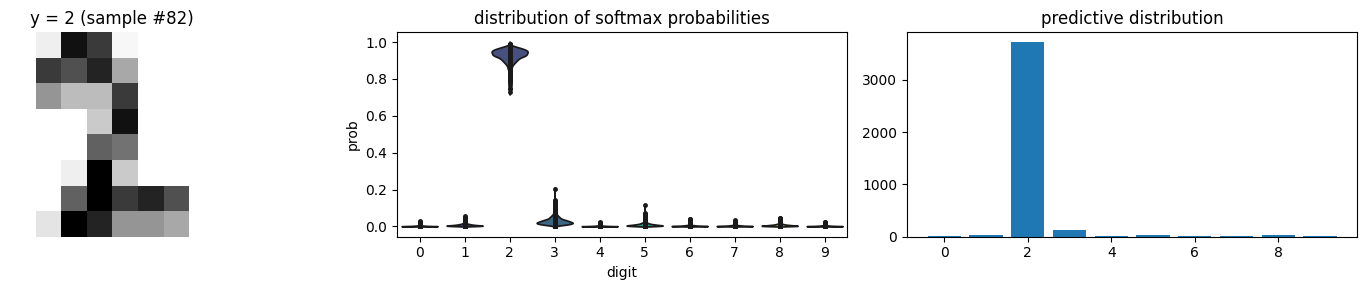

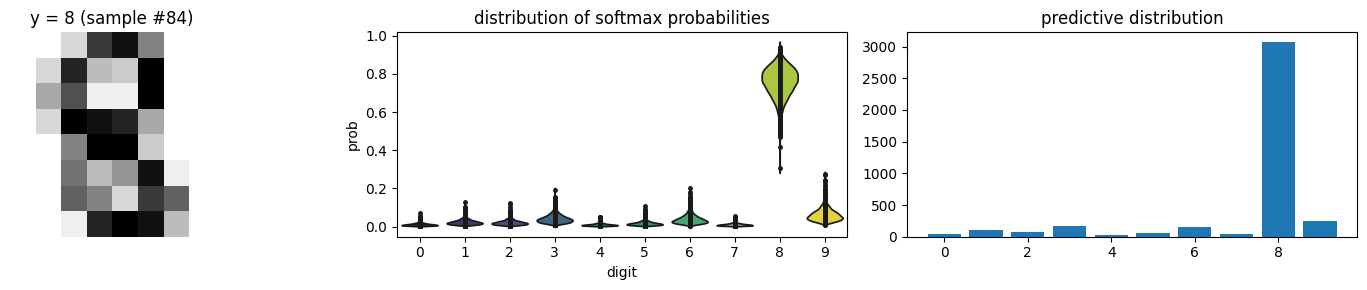

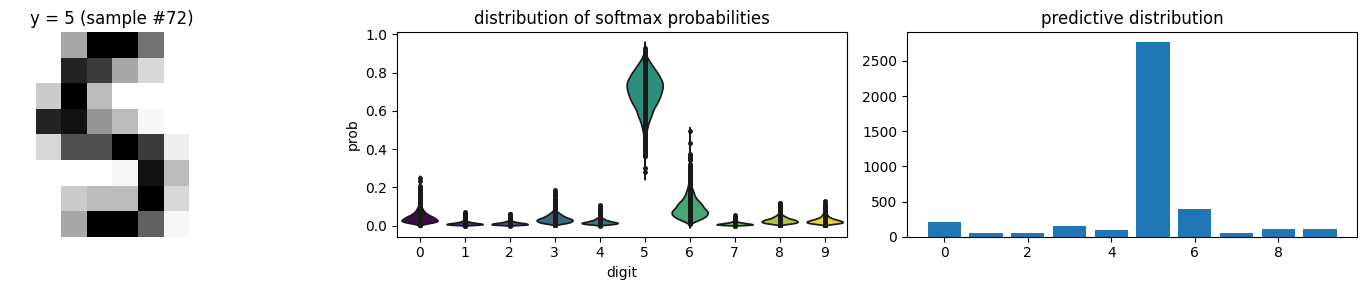

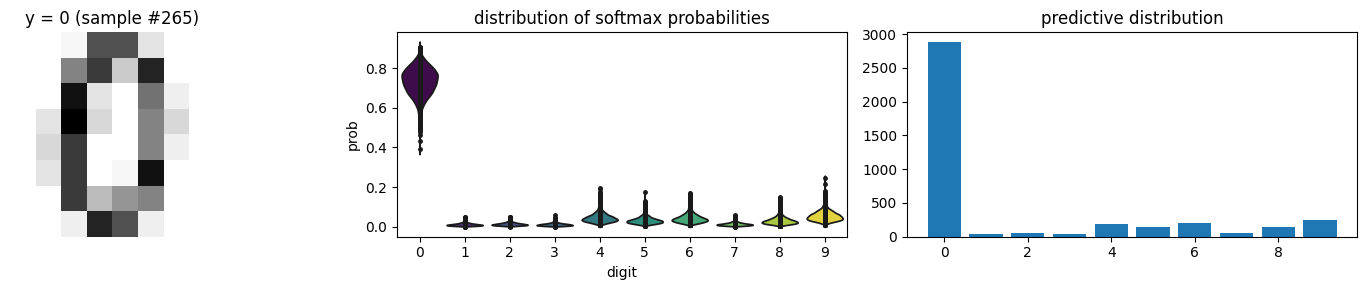

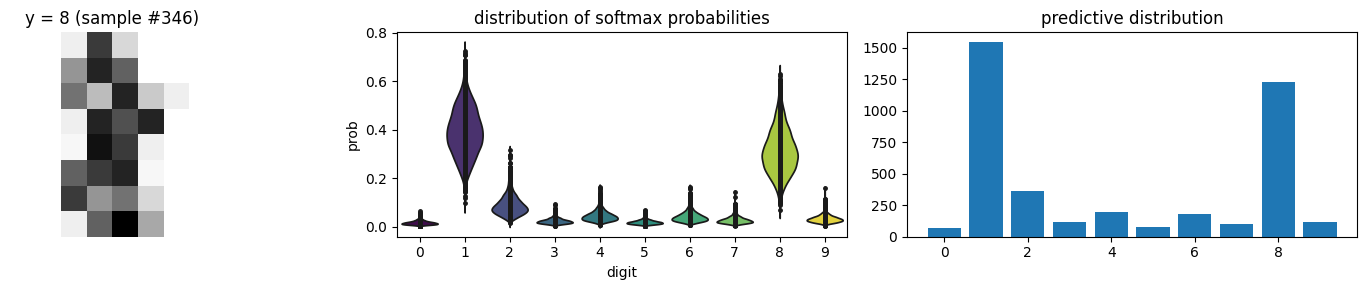

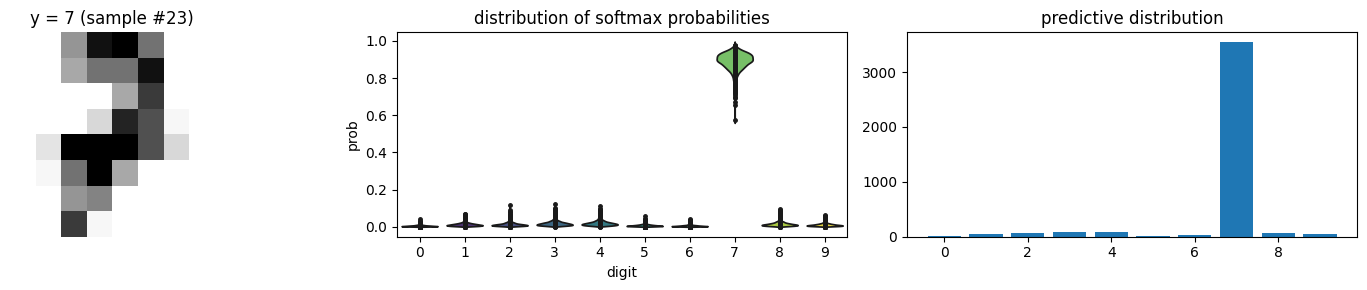

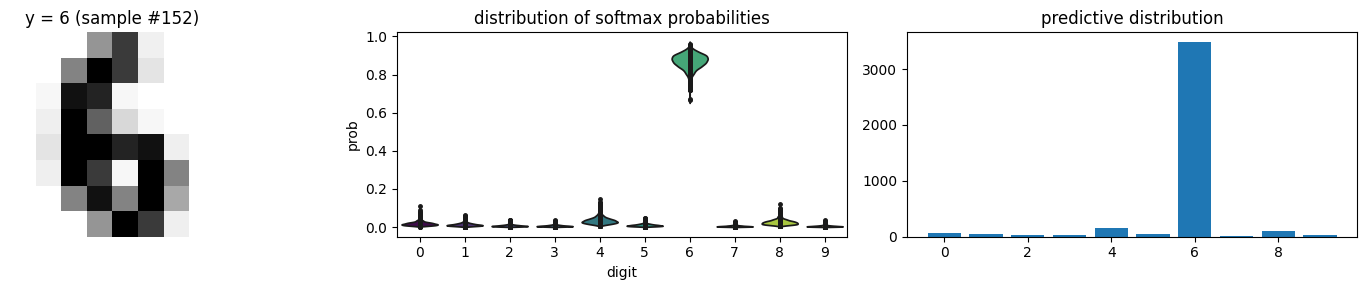

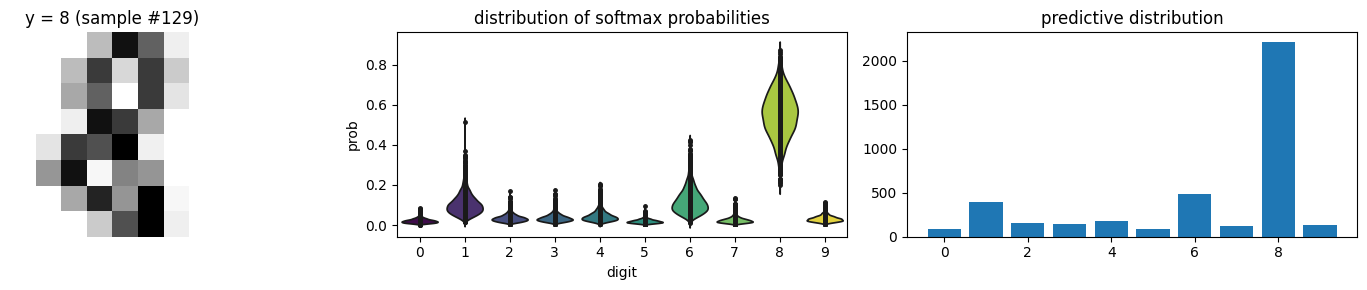

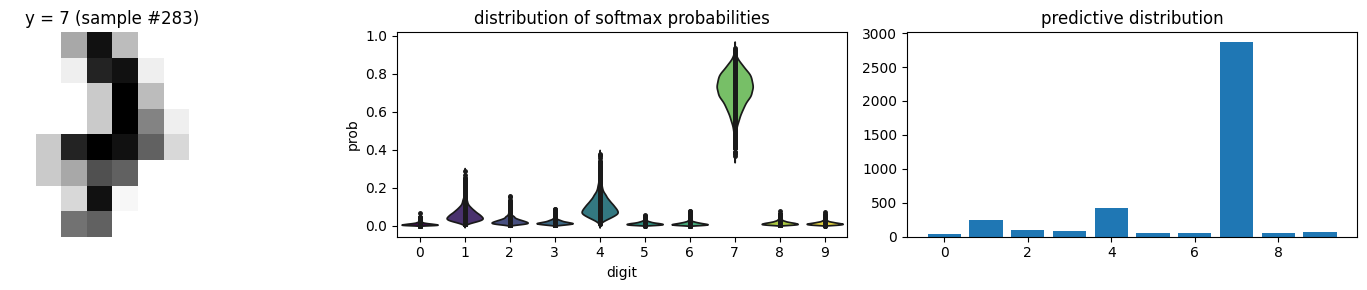

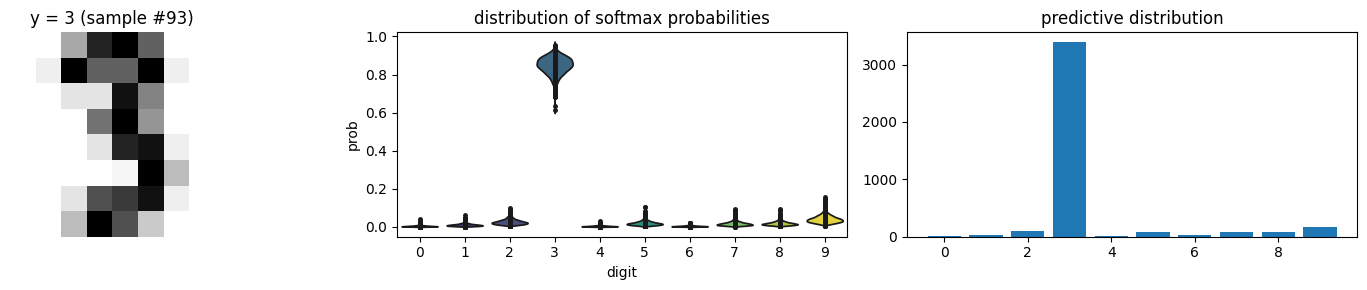

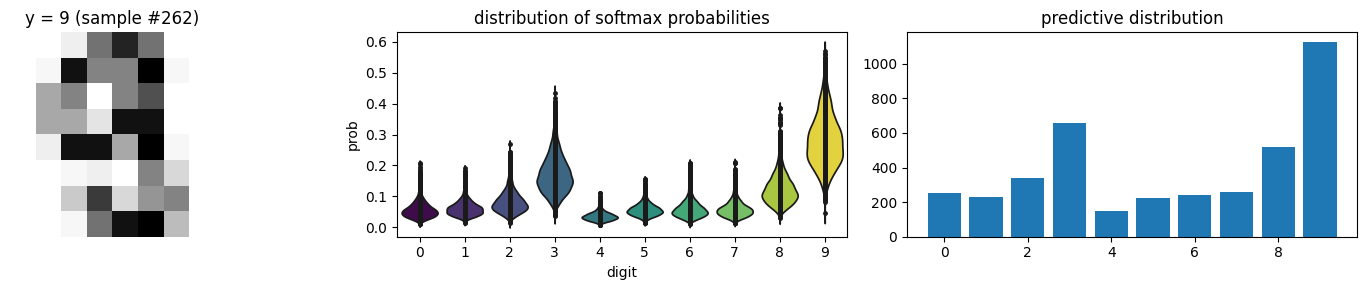

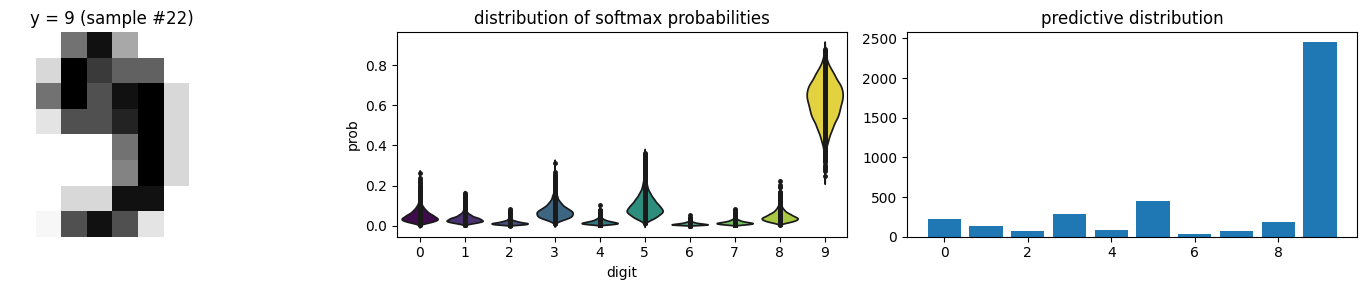

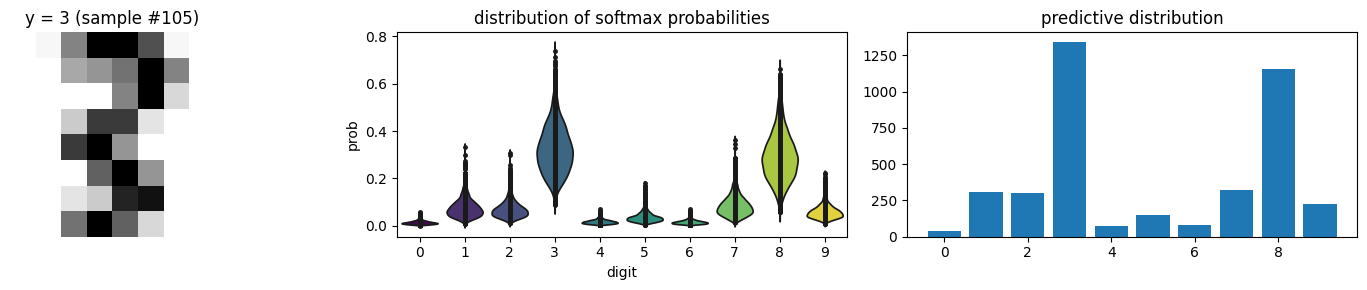

In [15]:
X_test_unscaled = scaler.inverse_transform(X_test)

# quick and handy function that uses global variables for readability - be careful when using this function out of notebook context
def plot_digit_summary( i ):
    counts = np.unique( preds[:,i], return_counts=True )
    d = pd.DataFrame(output_probs[:,i,:]).melt( var_name="digit", value_name="prob" )
    
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    ax[0].imshow( X_test_unscaled[i,:].reshape(8, 8), cmap="Greys" )
    ax[0].set_axis_off()
    ax[0].set_title( "y = {} (sample #{})".format(np.argmax(y_test[i]), i) )
    sns.violinplot( data=d, x="digit", y="prob", hue="digit", legend=False, palette="viridis", inner="point", ax=ax[1] )
    ax[1].set_title("distribution of softmax probabilities")
    ax[2].bar( counts[0], counts[1] )
    ax[2].set_title("predictive distribution")
    plt.tight_layout()

np.random.seed(1337)
for k in range(20):
    i = np.random.randint( X_test.shape[0] )
    plot_digit_summary( i )

## Assess Predictive Performance

Since the 10 classes are balanced, accuracy is a reasonable metric. However to compute the accuracy, we have to use an aggregate of the predictive distribution.

#### Using the mode of the predictive distribution:

In [16]:
mode_preds = np.array( [mode( preds[:,i] )[0] for i in range(X_test.shape[0])] )
y_test_labels = np.argmax( y_test, axis=1 )
np.mean( mode_preds == y_test_labels )

0.9416666666666667

This is comparable to a classical MLP optimized with stochastic gradient descent!

#### Overall accuracy per model (histogrammized for all 4000 models):

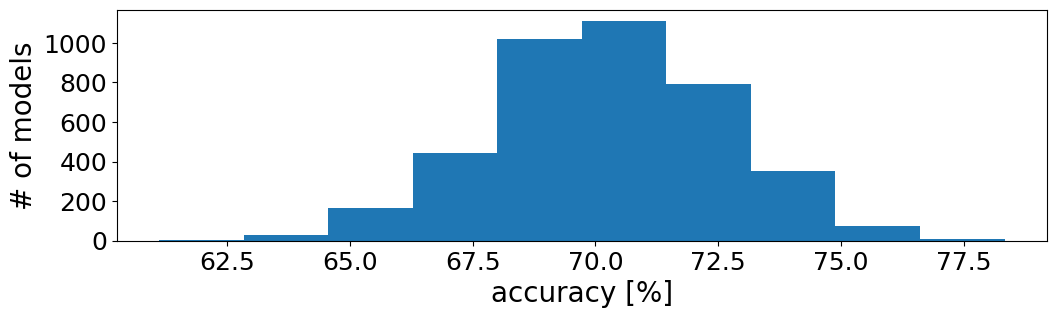

In [17]:
plt.figure( figsize=(12,3) )
plt.hist( np.mean(preds == y_test_labels, axis=1)*100 )
plt.xlabel("accuracy [%]", fontsize=20 )
plt.ylabel("# of models", fontsize=20 )
plt.xticks( fontsize=18 ); plt.yticks( fontsize=18 );

Per model the accuracy is actually rather low! It's the ensemble that reaches good accuracies!

## Using Bayesian model to compute epistemic uncertainty

A deep learning model typically has non-negligible epistemic uncertainty originating from the limited amount of training data and particularities of the training procedure. In the classic sense, a model returns different results every time it is re-trained (as it lands in different minima at the end of stochastic gradient descent). This dependence on initialisation is epistemic uncertainty, as it has nothing to do with the data, at least not in a direct sense.

For our Bayesian MLP, we have computed an ensemble of 4000 different models (4000 different $W_1$, $\mathbf{b}_1$, $W_2$ and $\mathbf{b}_2$). While this takes a considerable amount of time (MCMC), so would computing an ensemble of classic models with stochastic gradient descent. The ensembling mechanism allows us to assess the uncertainty of model predictions, as the 4000 models are distributed in a Gaussian-like manner around the mode of the network parameters. In the case of MNIST, we can assess whether all models predicted the same number (very certain) or whether different models predicted different numbers (uncertain) for the same sample.

An example with low uncertainty:

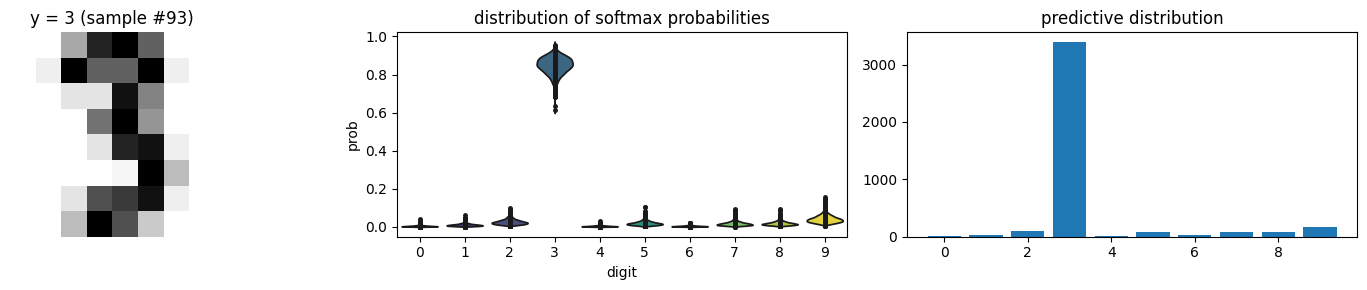

In [18]:
plot_digit_summary( 93 )

An example with high uncertainty:

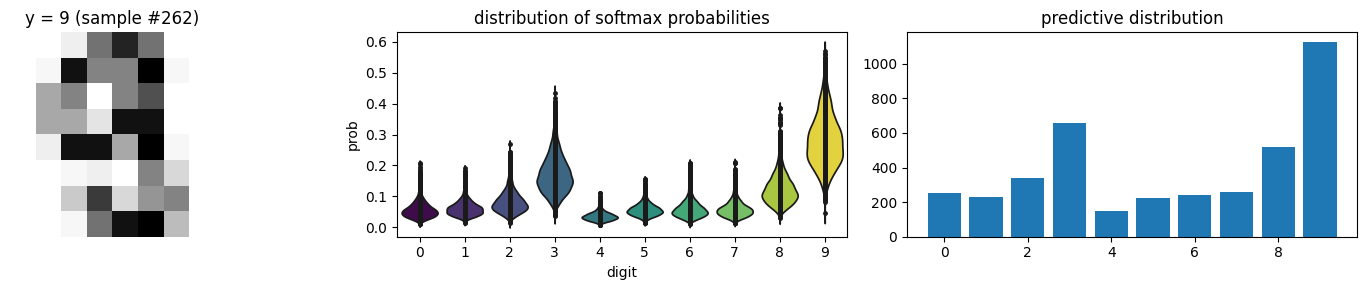

In [19]:
plot_digit_summary( 262 )

Knowledge of uncertainty can be very useful information if the decision taken from the predictions has critical consequences, for example for medical treatment or financial decisions.

## Compare with Classic MLP

Train weights:

In [20]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=1000, hidden_layer_sizes=(32), alpha=0).fit(X_train, y_train)

Accuracy:

In [21]:
y_test_pred = clf.predict( X_test )
np.mean( np.argmax( y_test_pred, axis=1 ) == np.argmax( y_test, axis=1 ) )

0.9583333333333334

Slightly better than the mode of the Bayesian MLP! Probably our priors are slightly too strongly concentrated around zero.

Also compute probabilities for later examples:

In [22]:
test_probs = clf.predict_proba( X_test )
test_probs.shape

(360, 10)

### Compare test sample #11 between the two different networks

Different model decisions of Bayesian MLP:

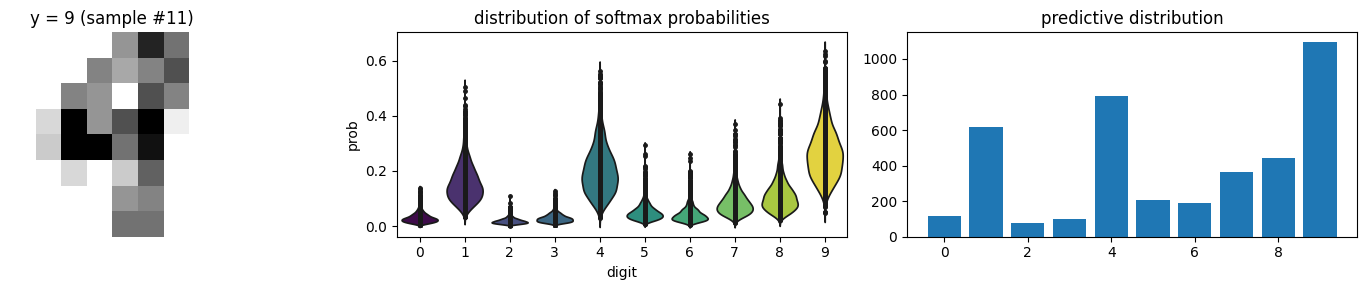

In [23]:
i = 11
plot_digit_summary( i )

Confidence (pseudo probabilities) of classic MLP:

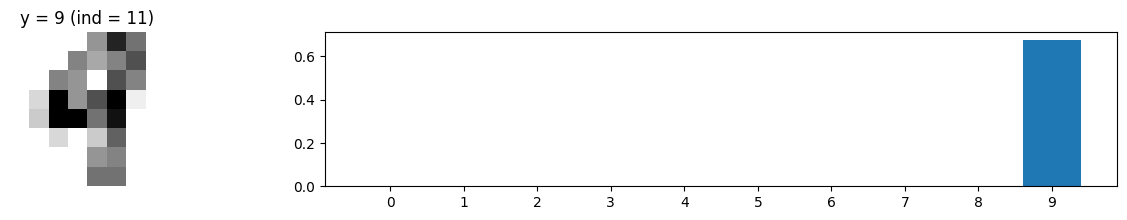

In [24]:
fig, ax = plt.subplots(1, 2, width_ratios=(1,3), figsize=(15,2))
ax[0].set_title( "y = {} (ind = {})".format(np.argmax(y_test[i]), i) )
ax[0].imshow( X_test_unscaled[i,:].reshape(8, 8), cmap="Greys" )
ax[0].set_axis_off()
ax[1].bar( np.arange(10), test_probs[i,:] )
ax[1].set_xticks( np.arange(10) );

Quite different! The classic MLP is overconfident. It is not so clear, that the digit is a 9, it could easily also be a 4!

## Out-of-Distribution Data

### Rotated 3

(-0.5, 7.5, 7.5, -0.5)

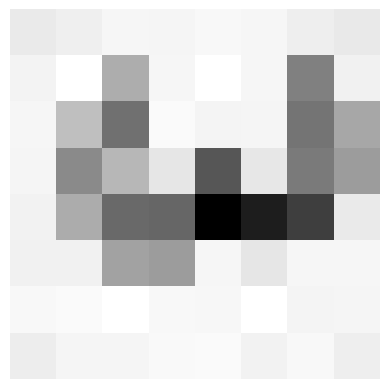

In [25]:
x = plt.imread("3_flat.jpg")
plt.imshow(x, cmap="Greys")
plt.axis("off")

Preprocess (standardize) and compute predictive distribution:

  0%|          | 0/4000 [00:00<?, ?it/s]

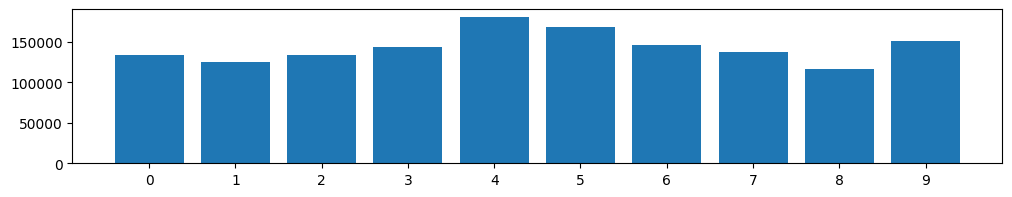

In [26]:
# forward prop
x_flat = scaler.transform(x.reshape(1,64))
hidden_test = np_relu( np.dot( x_flat, W1_post ) + b1_post )
output_logits = np.stack( [np.dot( hidden_test[:,i,:], W2_post[i,:,:] ) + b2_post[i,:] for i in range(W1_post.shape[0])], axis=0 )
output_probs = softmax( output_logits, axis=2 )

# predictive distribution with sampling
sample_preds = np.empty_like( output_probs[:,0,0] )
sample_preds[:] = np.nan
for i in tqdm(range(output_probs.shape[0])): # chains
    sample_preds[i] = np.argmax( multinomial.rvs( n=1, p=output_probs[i,0,:] ) )

# summarize predictive distribution in barplot
counts = np.unique( preds, return_counts=True )
plt.figure( figsize=(12,2) )
plt.bar( counts[0], counts[1] )
plt.xticks( np.arange(10) );

Probability distributions:

<Axes: xlabel='digit', ylabel='prob'>

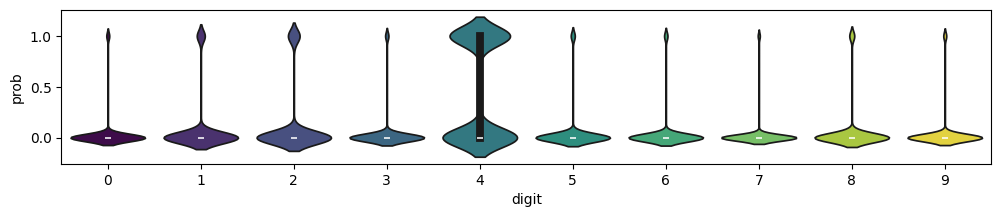

In [27]:
d = pd.DataFrame(output_probs[:,0,:]).melt( var_name="digit", value_name="prob" )
plt.figure( figsize=(12,2) )
sns.violinplot( data=d, x="digit", y="prob", hue="digit", legend=False, palette="viridis" )

#### MLP prediction is overconfident

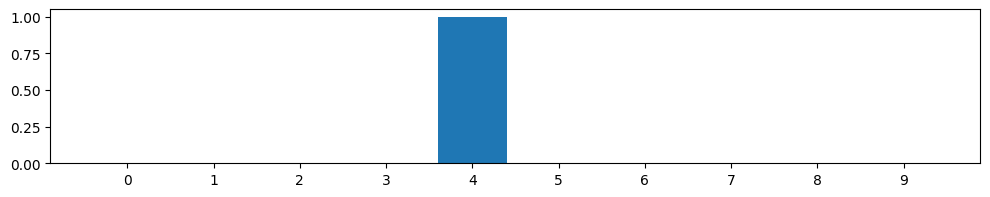

In [28]:
plt.figure( figsize=(12,2) )
plt.bar( np.arange(10), clf.predict_proba( x_flat )[0,:] )
plt.xticks( np.arange(10) );

The classical MLP is overconfident that we are dealing with a 1 - and wrong!

### Random data

(-0.5, 7.5, 7.5, -0.5)

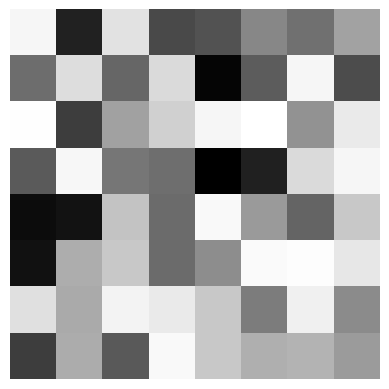

In [29]:
x = np.random.rand(8, 8)
plt.imshow(x, cmap="Greys")
plt.axis("off")

Forward prop and predictive distribution:

  0%|          | 0/4000 [00:00<?, ?it/s]

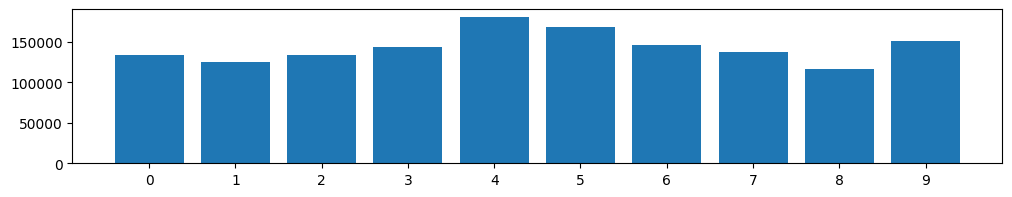

In [30]:
# forward prop
x_flat = scaler.transform(x.reshape(1,64))
hidden_test = np_relu( np.dot( x_flat, W1_post ) + b1_post )
output_logits = np.stack( [np.dot( hidden_test[:,i,:], W2_post[i,:,:] ) + b2_post[i,:] for i in range(W1_post.shape[0])], axis=0 )
output_probs = softmax( output_logits, axis=2 )

# predictive distribution with sampling
sample_preds = np.empty_like( output_probs[:,0,0] )
sample_preds[:] = np.nan
for i in tqdm(range(output_probs.shape[0])): # chains
    sample_preds[i] = np.argmax( multinomial.rvs( n=1, p=output_probs[i,0,:] ) )

# summarize predictive distribution in barplot
counts = np.unique( preds, return_counts=True )
plt.figure( figsize=(12,2) )
plt.bar( counts[0], counts[1] )
plt.xticks( np.arange(10) );

Uncertainty is clearly extremely high!

#### MLP prediction is overconfident again

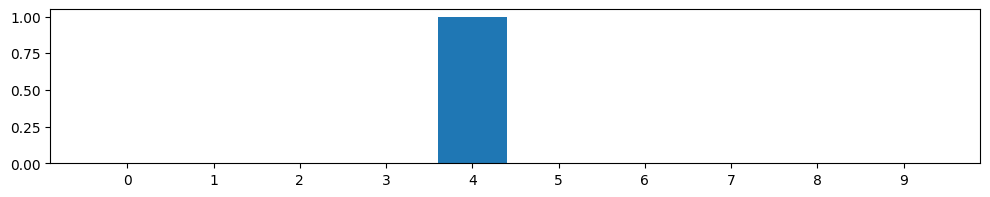

In [31]:
plt.figure( figsize=(12,2) )
plt.bar( np.arange(10), clf.predict_proba( x_flat )[0,:] )
plt.xticks( np.arange(10) );

Definitely wrong..